<a href="https://colab.research.google.com/github/src-by-hannah/gan_study/blob/main/dl_2021_gan_ch06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 6. 단순한 1010 패턴**

Make Your First GAN With PyTorch, 2020

<BR>
<BR>

**GAN 구조**

<img src = "https://t1.daumcdn.net/cfile/tistory/9933034C5B30A59B04">

In [ ]:
# import libraries

import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

## Data Functions

In [ ]:
# function to generate real data
# - 기댓값이 1.0인 data

def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)]) # 임의성을 추가하여 조금 더 실제 상황에 가깝게
    return real_data

In [ ]:
# function to generate uniform random data
# - 생성기 도입 전에, 판별기 성능 확인을 위한 random data

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

## Discriminator Network

In [ ]:
# discriminator class
# 판별기

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        # 신경망 레이어 
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        # - 판별기 update
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    def forward(self, inputs):
        # simply run model
        # nn.module을 오버라이딩 함
        return self.model(inputs)

    # 학습
    # - 보통은 따로 분리하여 작성함
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    # 차트 그리기
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## Test Discriminator

In [ ]:
# test discriminator can separate real data from random noise
# - random data를 이용해서 판별기 test

D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


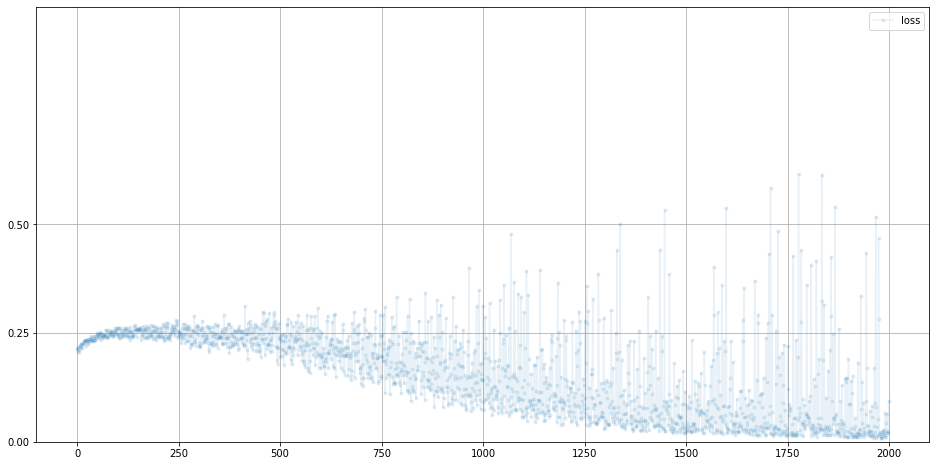

In [ ]:
# plot discriminator loss

D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake

print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7981621623039246
0.20744721591472626


## Generator Network

In [ ]:
# generator class
# 생성기
# - 판별기와 비슷한 구조에서 시작

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        # - 앞서 판별기의 network를 뒤집은 것과 동일
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        """
        # loss 함수를 구하지 않는 이유
        #
        # : loss 함수는 판별기 update 시에만 활용되므로
        # : 생성기는 판별기의 기울기 오차를 통해 update 됨
        """

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## Test Generator Output

: 학습 전, data format 확인

In [ ]:
# check the generator output is of the right type and shape

G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.4389, 0.6330, 0.6380, 0.6206], grad_fn=<SigmoidBackward>)

## Train GAN (훈련)

In [ ]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # [1단계]
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # [2단계]
    # train discriminator on false
    # - use detach() so gradients in G are not calculated
    # - 2단계에서는, 계산 graph에서 생성기를 떼어내어 그의 기울기가 계산되지 않도록
    # - 이는 계산의 효율성을 위함
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # [3단계]
    # train generator
    # - 3단계에서는 기울기가 생성기에 전달되도록 datach() XXX
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 12.9 s, sys: 39.9 ms, total: 12.9 s
Wall time: 12.9 s


### **잘 훈련된 GAN**

: 출력이 0.5인 즉, 생성된 가짜 이미지와 실제 이미지를 잘 구별하지 못하는 상태

: 평균제곱오차에 의해 0.25가 이상치

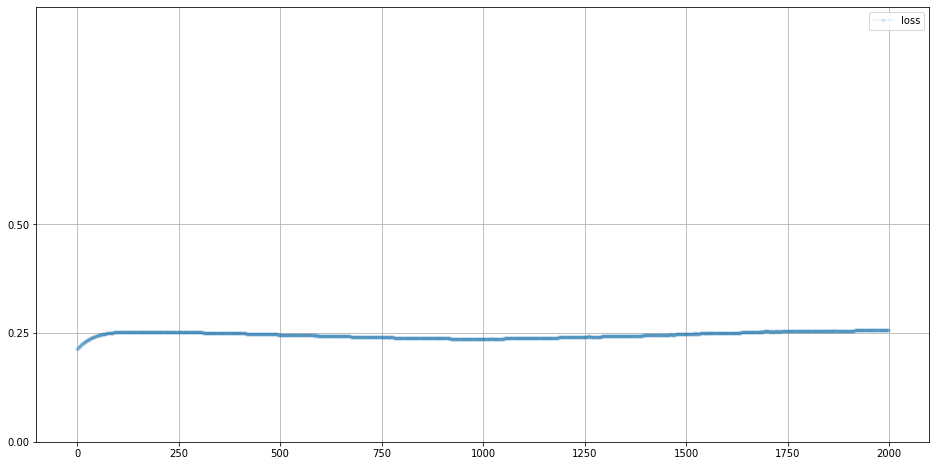

In [ ]:
# plot discriminator error

D.plot_progress()

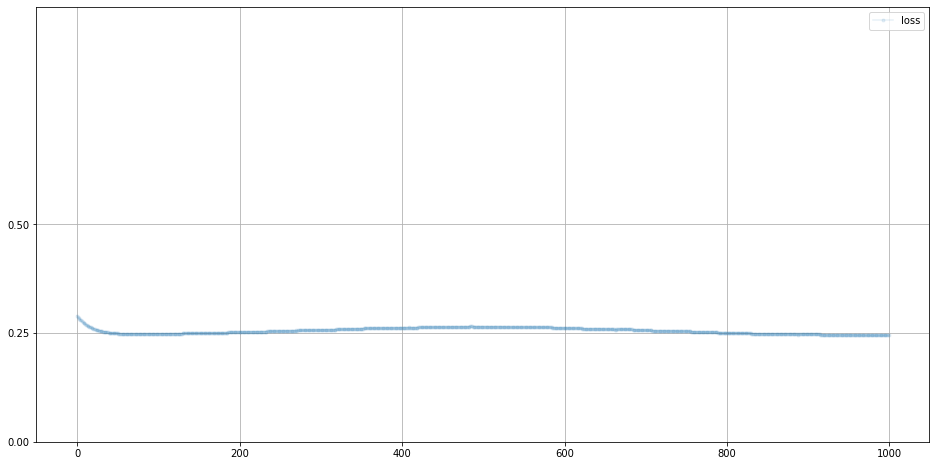

In [ ]:
# plot generator error

G.plot_progress()

## Manually Run Generator

: 생성기 학습 후, 1010 패턴과 유사함

In [ ]:
# manually run generator to see it's outputs

G.forward(torch.FloatTensor([0.5]))

tensor([0.9004, 0.0474, 0.8357, 0.0771], grad_fn=<SigmoidBackward>)

## Visualise Pattern During Training

: 생성기가 훈련되며 어떻게 변하는지 그 과정을 visualization

: 훈련이 계속될수록 뚜렷한 1010 패턴을 보여줌

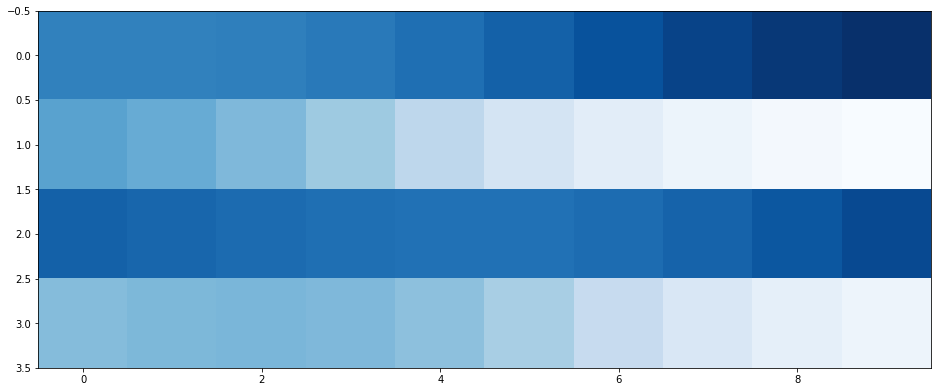

In [ ]:
# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')